In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from sklearn.cross_decomposition import PLSRegression, PLSCanonical
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, cross_val_score

from sys import stdout

from helpers import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
ROOT_FOLDER = "../"
DATA_FOLDER = "data/processed/"

INPUT_LAB_SPEC_TRAIN = ROOT_FOLDER + DATA_FOLDER + "input_lab_spec_train.csv"
INPUT_LAB_SPEC_TEST = ROOT_FOLDER + DATA_FOLDER + "input_lab_spec_test.csv"

INPUT_LAB_CONC_TRAIN = ROOT_FOLDER + DATA_FOLDER + "input_lab_conc_train.csv"
INPUT_LAB_CONC_TEST = ROOT_FOLDER + DATA_FOLDER + "input_lab_conc_test.csv"

INPUT_AMB_SPEC = ROOT_FOLDER + DATA_FOLDER + "input_amb_spec.csv"
INPUT_AMB_CONC = ROOT_FOLDER + DATA_FOLDER + "input_amb_conc.csv"

# Loading the data

In [4]:
# Import Laboratory data

file_lab_spec_train = pd.read_csv(INPUT_LAB_SPEC_TRAIN, header=None)
file_lab_spec_test = pd.read_csv(INPUT_LAB_SPEC_TEST, header=None)
file_lab_conc_train = pd.read_csv(INPUT_LAB_CONC_TRAIN, header=None)
file_lab_conc_test = pd.read_csv(INPUT_LAB_CONC_TEST, header=None)

X_lab_train = pd.DataFrame(file_lab_spec_train).values.T
y_lab_train = pd.DataFrame(file_lab_conc_train).values.ravel()

X_lab_test = pd.DataFrame(file_lab_spec_test).values.T
y_lab_test = pd.DataFrame(file_lab_conc_test).values.ravel()

print("Train :\n")
print(X_lab_train.shape)
print(y_lab_train.shape)
print("\nTest :\n")
print(X_lab_test.shape)
print(y_lab_test.shape)

Train :

(144, 2784)
(144,)

Test :

(74, 2784)
(74,)


In [5]:
# Import Ambient data

file_amb_spec = pd.read_csv(INPUT_AMB_SPEC, header=None)
file_amb_conc = pd.read_csv(INPUT_AMB_CONC, header=None)

X_amb = pd.DataFrame(file_amb_spec).values.T
y_amb = pd.DataFrame(file_amb_conc).values.ravel()

print(X_amb.shape)
print(y_amb.shape)

(2230, 2784)
(2230,)


# Partial Least Squares

## Part I : Build model and use CV to determine optimal parameter

In [6]:
# Define PLS model using NIPALS algorithm
pls = PLSRegression(n_components=10, scale=False, tol=1e-6, max_iter=500)
pls.fit(X_lab_train, y_lab_train)

# Cross-validation using venetian blind
nb_fold = 10
indices_venet = build_k_indices(y_lab_train, nb_fold)
score_cv = cross_val_score(pls, X_lab_train, y_lab_train, cv=indices_venet, \
                           scoring='neg_mean_squared_error') # Calculate scores

In [7]:
def optimise_pls_cv(X_train, X_test, y_train, y_test, n_comp, plot_components=True):
    
    '''Run PLS including a variable number of components, from 1 to n_comp,
       and calculate RMSE '''
    
    rmsecv = []
    rmsep = []
    component = np.arange(2, n_comp)
    
    for i in component:
        pls = PLSRegression(n_components=i, scale=False, tol=1e-6, max_iter=500)
        
        # Venetian blind cross-validation
        indices_venet = build_k_indices(y_train, nb_fold=5)
        
        score_cv = np.mean(cross_val_score(pls, X_train, y_train, cv=indices_venet, \
                                           scoring='neg_root_mean_squared_error'))
        rmsecv.append(-score_cv)
        
        # Prediction
        pls.fit(X_train, y_train)
        y_predict = pls.predict(X_test)
        score_p = np.sqrt(mean_squared_error(y_predict, y_test))
        rmsep.append(score_p)
        comp = 100*(i+1)/n_comp
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    
    # Calculate and print the position of minimum in MSE
    rmsemin = np.argmin(rmsecv)
    print("Suggested number of components : ", rmsemin+1)
    stdout.write("\n")
    print("Minimum RMSECV : ", np.array(rmsecv)[rmsemin])
    print("Minimum RMSEP : ", np.array(rmsep)[rmsemin])
    
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(rmsecv), '-+', color = 'blue', mfc='blue')
            plt.plot(component, np.array(rmsep), '-+', color = 'green', mfc='green')
            plt.plot(component[rmsemin], np.array(rmsecv)[rmsemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('RMSE')
            plt.title('PLS')
            plt.xlim(left=-1)
            plt.yscale('log')
        plt.show()
        
    return

100% completed
Suggested number of components :  23

Minimum RMSECV :  5.003720848957845e-15
Minimum RMSEP :  0.7332156928067941


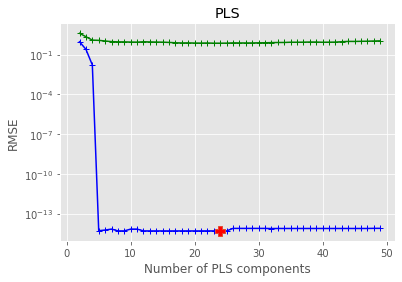

In [9]:
optimise_pls_cv(X_lab_train, X_lab_test, y_lab_train, y_lab_test, 50, plot_components=True)

In [27]:
def nb_fold_cv(X_train, X_test, y_train, y_test, n_comp):
    
    '''Run PLS including a variable number of components, from 1 to n_comp,
       and calculate RMSE '''
    
    component = np.arange(10, n_comp)
    nb_fold = np.arange(2, 10)
    
    rmsecv = np.zeros((len(component), len(nb_fold)))
    rmsep = np.zeros((len(component), len(nb_fold)))
    
    for f in nb_fold:
        for i in component:
            pls = PLSRegression(n_components=i, scale=False, tol=1e-6, max_iter=500)
        
            # Venetian blind cross-validation
            indices_venet = build_k_indices(y_train, nb_fold=f)
        
            score_cv = np.mean(cross_val_score(pls, X_train, y_train, cv=indices_venet, \
                                           scoring='neg_root_mean_squared_error'))
            rmsecv[i-10,f-2] = -score_cv
        
            # Prediction
            pls.fit(X_train, y_train)
            y_predict = pls.predict(X_test)
            score_p = np.sqrt(mean_squared_error(y_predict, y_test))
            
            rmsep[i-10,f-2] = score_p
            
            comp = 100*(i+1)/n_comp
            # Trick to update status on the same line
            stdout.write("\r%d%% completed" % comp)
            stdout.flush()
        stdout.write("\n")
    
    fig, ax = plt.subplots(figsize=(10,6))
    with plt.style.context(('ggplot')):
        ax.plot(component, rmsecv, '-+')
        plt.xlabel('Number of PLS components')
        plt.ylabel('RMSE')
        plt.title('PLS')
        plt.xlim(left=-1)
        plt.yscale('log')
    plt.show()
        
    return

100% completed
100% completed
100% completed
100% completed
100% completed
100% completed
100% completed
100% completed


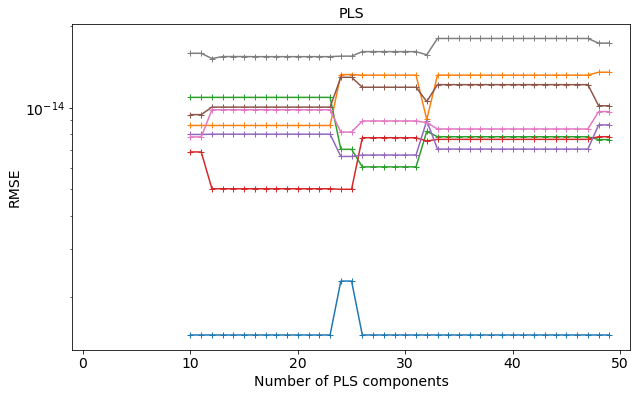

In [28]:
nb_fold_cv(X_lab_train, X_lab_test, y_lab_train, y_lab_test, 50)

## Part 2 : Train on laboratory samples and test on laboratory + ambient samples

In [9]:
# Define PLS model using NIPALS algorithm
pls = PLSRegression(n_components=23, scale=False, tol=1e-6, max_iter=500)
pls.fit(X_lab_train, y_lab_train)

y_amb_predict = pls.predict(X_amb)
rmse_amb = np.sqrt(mean_squared_error(y_amb_predict, y_amb))
print(rmse_amb)

y_lab_predict = pls.predict(X_lab_test)
rmse_lab = np.sqrt(mean_squared_error(y_lab_predict, y_lab_test))
print(rmse_lab)

13.279424794794053
0.7370432925347091


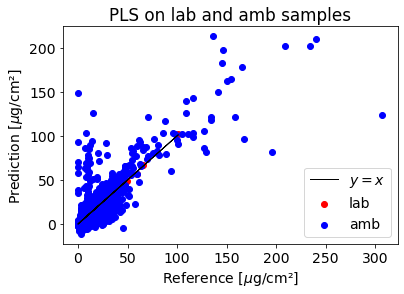

In [10]:
# Fit a line between reference and prediction

fig = plt.figure()
# z = np.polyfit(y_ref, y_pred, 1)
plt.scatter(y_lab_test, y_lab_predict, c='red', label='lab')
plt.scatter(y_amb, y_amb_predict, c='blue', label='amb')
#Plot the best fit line
# plt.plot(y_ref, np.polyval(z, y_ref), c='green', linewidth=1, label='fit')
plt.plot(y_lab_test, y_lab_test, color='black', linewidth=1, label='$y=x$') # line y = x 
plt.xlabel('Reference [$\mu$g/cm²]')
plt.ylabel('Prediction [$\mu$g/cm²]')
plt.legend()
plt.title('PLS on lab and amb samples')
plt.show()

In [11]:
fig.savefig('model_fits.png', dpi=100, bbox_inches = "tight")

## Part 3 : Train on ambient samples and test on ambient + laboratory samples

In [17]:
from sklearn.model_selection import train_test_split

# Not the best way to do it, but it is only to get a result.
X_amb_train, X_amb_test, y_amb_train, y_amb_test = train_test_split(X_amb, y_amb, test_size=0.2, random_state=42)

In [18]:
# Define PLS model using NIPALS algorithm
pls = PLSRegression(n_components=23, scale=False, tol=1e-6, max_iter=500)
pls.fit(X_amb_train, y_amb_train)

y_amb_predict = pls.predict(X_amb_test)
rmse_amb = np.sqrt(mean_squared_error(y_amb_predict, y_amb_test))
print(rmse_amb)

y_lab_predict = pls.predict(X_lab_test)
rmse_lab = np.sqrt(mean_squared_error(y_lab_predict, y_lab_test))
print(rmse_lab)

3.7168608985096325
33.72264297925735


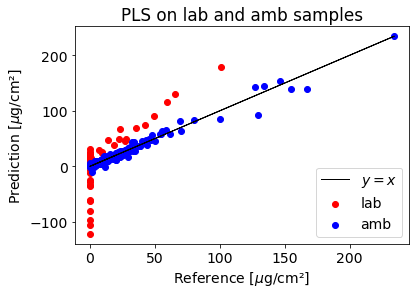

In [19]:
# Plot prediction vs reference
plt.scatter(y_lab_test, y_lab_predict, c='red', label='lab')
plt.scatter(y_amb_test, y_amb_predict, c='blue', label='amb')
plt.plot(y_amb_test, y_amb_test, color='black', linewidth=1, label='$y=x$') # line y = x 
plt.xlabel('Reference [$\mu$g/cm²]')
plt.ylabel('Prediction [$\mu$g/cm²]')
plt.legend()
plt.title('PLS on lab and amb samples')
plt.show()

In [63]:
fig.savefig('model_fits.png', dpi=100, bbox_inches = "tight")